### GAN
Ostatnia aktualizacja: 2021.01.29

Na początek importy. 

```python
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist

#### Dane
Wczytajmy dane treningowe - [MNIST](https://keras.io/datasets/) do zmiennej X_train.  Nie interesują nas dane testowe i etykiety, bo nasz dyskryminator zgaduje tylko czy dane są prawdziwe, czy fałszywe.
Nasz generator będzie na wyjściu miał [funkcję aktywacji tanh](https://cs-cheatsheet.readthedocs.io/en/latest/_images/activation_functions.png), zwracającą wartości w przedziale -1,1, dlatego musimy dostosować nasze dane tak, aby pixel o wartości 0 miał teraz wartość -1, a pixel o wartości 255 miał wartość 1. Dane powinny być w postaci wektora (1 wymiar). 

In [14]:
(X_train,_ ),(_,_)= mnist.load_data()
X_train = X_train/(127.5) -1
X_train = X_train.astype(np.float32)
X_train = X_train.reshape(X_train.shape[0], 28*28)

In [15]:
print(np.min(X_train),np.max(X_train))

-1.0 1.0


#### Generator
Generator, czyli sieć, która będzie nam tworzyć dane. Na wejściu będzie dostawała 100 losowych zmiennych, a na wyściu będzie zwracać 28*28 wartości - pixeli w przedziale -1,1.  
Używamy aktywacji LeakyReLU - w Keras bardziej 'zaawansowane' funkcje aktywacji tworzymy jako oddzielne warstwy (zamiast jako argument poprzedniej warstwy, np. Dense lub Conv2D). 

Zróbmy generator. Będzie to MLP zbudowany z 4 warstw Dense (tzw. Fully Connected): 256 jednostek (input_dim=100), 512, 1028, a w ostatniej tyle, ile pixeli. Po każdej warstwie Dense oprócz ostatniej umieszczamy warstwę LeakyReLU(0.2). 

In [19]:
generator = Sequential([
    Dense(256, input_dim = 100),LeakyReLU(0.2),
    Dense(512),LeakyReLU(0.2),
    Dense(1024),LeakyReLU(0.2),
    Dense(28*28, activation = 'tanh'),
])

#### Dyskryminator
Dyskryminator, czyli sieć odgadująca czy input jest prawdziwy, czy fałszywy. Dlatego na wyjściu ma tylko jedną wartość - tym razem sigmoid, czyli wartość w przedziale (0,1).  
Zróbmy dyskryminator, który będzie miał 4 warstwy Dense: 1024 (input_dim tyle, ile pixeli ma obrazek lub wyjście generatora), 512, 256, i na koniec 1 (activation='sigmoid'). Po każdej LeakyReLU(0.2).

In [20]:
discriminator = Sequential([
    Dense(1024, input_dim = 28*28),LeakyReLU(0.2),
    Dense(512),LeakyReLU(0.2),
    Dense(256),LeakyReLU(0.2),
    Dense(1, activation = 'sigmoid'),
])

#### GAN
Zróbmy sobie GAN, czyli sieć łączącą generator z dyskryminatorem. 
```python
gan = Sequential([generator, discriminator])
```

Przed treningiem musimy wywołać metodę compile dyskryminatora i GAN'a, która pozwala nam skonfigurować trening sieci.  
Uwaga: ponieważ będziemy w trakcie treningu wyłączać trening dyskryminatora, przed kompilacją GAN'a musimy ustawić mu parametr trainable na false [(inaczej GAN zignoruje zmiany tej flagi w aktualnej wersji Keras)](
https://stackoverflow.com/questions/51108076/generative-adversarial-networks-in-keras-doesnt-work-like-expected).

Nasz kod będzie wyglądał tak: 
```python
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
discriminator.trainable=False
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
```


In [21]:
gan = Sequential([generator, discriminator])

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
discriminator.trainable=False
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))


#### Trening
Teraz zrobimy sobie pętlę, w której: 
- **trening dyskryminatora**: będziemy brać po 256 prawdziwych obrazków (którym przypiszemy etykiety '1') oraz generować 256 sztucznych obrazków (etykiety '0'). Będziemy na nich ćwiczyć nasz discriminator (discriminator.train_on_batch) . Cel treningu: odróżnianie prawdziwych obrazków od fałszywych. 
- **trening generatora**: następnie będziemy sobie robić 256 sztucznych obrazków, ale tym razem z etykietami 1 (czyli podajemy sztuczne obrazki jako prawdziwe!). Na nich będziemy ćwiczyć GAN (czyli generator podłączony do dyskryminatora), ale z wyłączonym treningiem discriminatora. Discriminator nie ma tu czego się uczyć, bo dostaje oszukane dane (sztuczne obrazki opisane jako prawdziwe), więc uczył się będzie tylko generator. Generator będzie do treningu korzystał z feedbacku, który da mu discriminator. Czyli discriminator patrzy na fałszywy obrazek podpisany jako prawdziwy i naiwnie mówi - 'ale jakto?! Przecież to kompletnie nie wygląda jak cyfra, bo ma to i to'. A generator słucha, wyciąga wnioski i zaciera ręce. 

Przydadzą nam się funkcje: 
```python
def random_input(instance_count):
  '''Zwraca losowy input dla generatora'''
  return np.random.normal(0,1,[instance_count, 100])
```

Epoka to zazwyczaj przejście przez cały zbiór treningowy. Zróbmy sobie taką pętlę: 

```python
batch_size = 256 # mozna poeksperymentowac - 128, 512, etc
batch_count = int(X_train.shape[0] / batch_size) # przyblizona liczba batchy w epoce

for epoch in range(21): # jak mamy czas, zwiekszmy liczbe epok
  print("Epoch {}".format(epoch))
  # generujemy i rysujemy 3 losowe obrazki (generator.predict, na wejsciu random_input)
  '...'
  
  # dla kazdego batch'a w tej epoce
  for batch in range(batch_count):
    # generujemy 256 sztucznych obrazkow (X_fake) i 256 etykiet 0 (y_fake)
    '...'
    
    # bierzemy 256 prawdziwych obrazkow (X_real) i robimy 256 etykiet 1 (y_real)
    '...'
    
    # laczymy sztuczne i prawdziwe dane i etykiety w zmienne X i y
    '...'
    
    # trenujemy dyskryminator na X i y (trzeba ustawic .trainable na True)
    '...'

    # wylaczamy trening dyskryminatora i trenujemy generator na sztucznych obrazkach opisanych jako 1
    '...'
```

In [22]:
def random_input(instance_count):
  '''Zwraca losowy input dla generatora'''
  return np.random.normal(0,1,[instance_count, 100])

Epoch 0


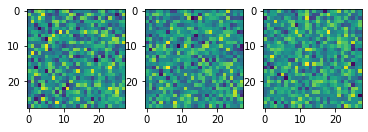

Epoch 1


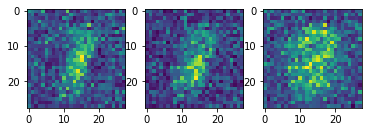

Epoch 2


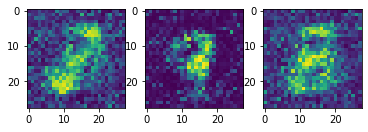

Epoch 3


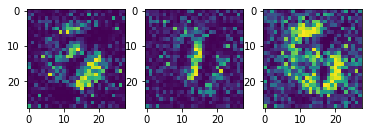

Epoch 4


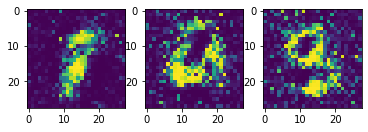

Epoch 5


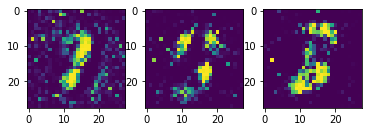

Epoch 6


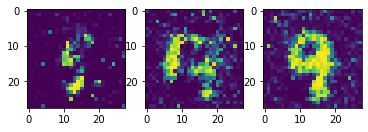

Epoch 7


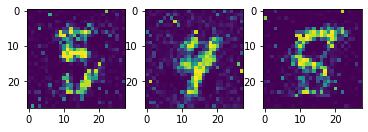

Epoch 8


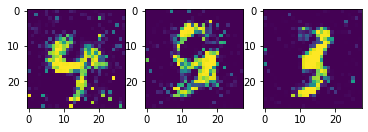

Epoch 9


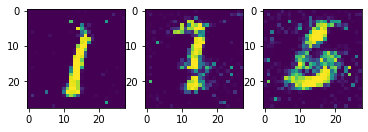

Epoch 10


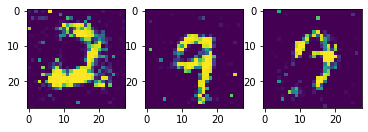

Epoch 11


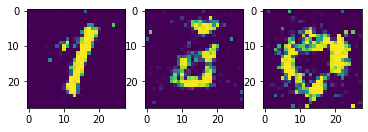

Epoch 12


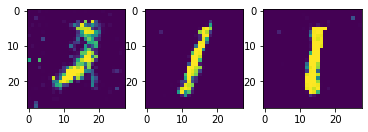

Epoch 13


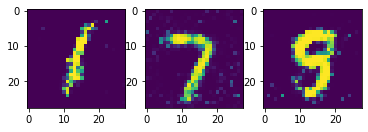

Epoch 14


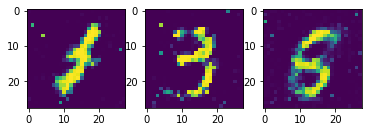

Epoch 15


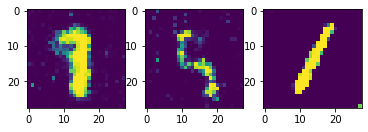

Epoch 16


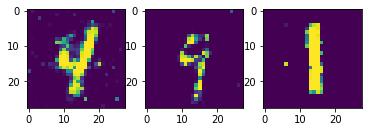

Epoch 17


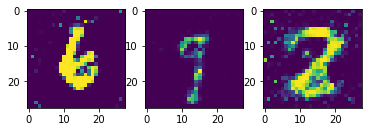

Epoch 18


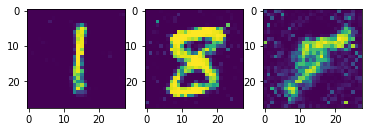

Epoch 19


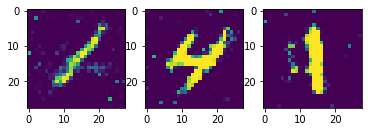

Epoch 20


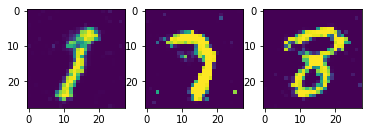

In [32]:
batch_size = 256 # mozna poeksperymentowac - 128, 512, etc
batch_count = int(X_train.shape[0] / batch_size) # przyblizona liczba batchy w epoce

for epoch in range(21): # jak mamy czas, zwiekszmy liczbe epok
  print("Epoch {}".format(epoch))
  # generujemy i rysujemy 3 losowe obrazki (generator.predict, na wejsciu random_input)
  images = generator.predict(random_input(3))
  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i].reshape(28,28))
  plt.show()
  # dla kazdego batch'a w tej epoce
  
  for batch in range(batch_count):
    # generujemy 256 sztucznych obrazkow (X_fake) i 256 etykiet 0 (y_fake)
    X_fake = generator.predict(random_input(batch_size))
    y_fake = np.zeros(batch_size)
    
    # bierzemy 256 prawdziwych obrazkow (X_real) i robimy 256 etykiet 1 (y_real)
    rand_ind = np.random.randint(0, X_train.shape[0], batch_size)
    X_real = X_train[rand_ind]
    y_real = np.ones(batch_size)

    # laczymy sztuczne i prawdziwe dane i etykiety w zmienne X i y
    X = np.concatenate([X_fake, X_real])
    y = np.concatenate([y_fake, y_real])
    
    # trenujemy dyskryminator na X i y (trzeba ustawic .trainable na True)
    discriminator.trainable = True
    discriminator.train_on_batch(X,y)

    # wylaczamy trening dyskryminatora i trenujemy generator na sztucznych obrazkach opisanych jako 1
    discriminator.trainable = False
    gan.train_on_batch(random_input(batch_size), np.ones(batch_size))


Jeśli działa, zobaczmy jak sobie poradzi z czapkami i trampkami (mnist_fashion)!  
Możemy też poeksperymentować z sieciami i treningiem, np. pozmieniać trochę warstwy, dodać dropout w discriminatorze, podłubać w optimizerach itp. 